# Image segmentation (3D UNET)
- 이번 실습에서는 3D U-NET을 이용하여 brain MRI image로부터 tumor region을 segmentation하는 model을 학습합니다.
- Generality를 높이기 위한 input data에 대한 transform을 추가해보도록 합니다.
- 3D U-NET의 구조를 바꾸어 보고, 다른 3D segmentation model을 적용하여 학습과정 및 결과를 비교합니다.
- Loss function을 다르게 적용하여 이에 의한 영향을 확인해 봅니다. 


In [1]:
!python -c "import monai" || pip install -q "monai-weekly[nibabel]"
!python -c "import matplotlib" || pip install -q matplotlib

In [2]:
path0 = '/content/drive/MyDrive/data/brats18/brats18_train' # replace your data path
dpiv = 80

In [3]:
from monai.transforms import (
    AddChanneld,
    Compose,
    LoadImaged,
    CenterSpatialCropd,
    NormalizeIntensityd,
    RandSpatialCropd,
    MapTransform,
    ToTensord,
)
from monai.config import print_config
from monai.data import DataLoader, Dataset
from monai.utils import first

from monai.losses import DiceLoss
from monai.metrics import DiceMetric
from monai.networks.nets import UNet
from monai.inferers import sliding_window_inference
from monai.networks.layers import Norm

import torch
import torch.nn as nn
import torch.optim as optim

import numpy as np
import matplotlib.pyplot as plt
import os
import glob

In [4]:
if torch.cuda.is_available():
  device = torch.device('cuda:0')
else:
  device = torch.device('cpu')

print(device)

cuda:0


In [5]:
path_list = glob.glob(os.path.join(path0,'Brats18*'))
len(path_list)

100

### data split (train/valid)

In [6]:
train_ind = np.arange(0,64)
data_dicts = [
    {
        "image": os.path.join(path_list[idx],
                                    "t1ce.nii.gz"),
        "label": os.path.join(path_list[idx],
                                    "seg.nii.gz"),
    }
    for idx in train_ind
]
train_files =  data_dicts

In [7]:
valid_ind = np.arange(64,80)
data_dicts = [
    {
        "image": os.path.join(path_list[idx],
                                    "t1ce.nii.gz"),
        "label": os.path.join(path_list[idx],
                                    "seg.nii.gz"),
    }
    for idx in valid_ind
]
valid_files =  data_dicts

In [8]:
train_transforms = Compose(
    [
      LoadImaged(keys=("image","label")),
      AddChanneld(keys=("image","label")),
      CenterSpatialCropd(keys=["image", "label"], roi_size=[224, 224, 96]),
      NormalizeIntensityd(keys="image", nonzero=True, channel_wise=True),
      RandSpatialCropd(keys=["image", "label"], roi_size=[160, 160, 64],random_size=False),
      ToTensord(keys=["image", "label"]),
    ]
)

valid_transforms = Compose(
    [
      LoadImaged(keys=("image","label")),
      AddChanneld(keys=("image","label")),
      NormalizeIntensityd(keys="image", nonzero=True, channel_wise=True),
      ToTensord(keys=["image", "label"]),
    ]
)

In [9]:
train_ds = Dataset(data = train_files, transform = train_transforms)
train_loader = DataLoader(train_ds,batch_size = 2)

In [10]:
valid_ds = Dataset(data = valid_files, transform = valid_transforms)
valid_loader = DataLoader(valid_ds,batch_size = 1)

- transform이 제대로 적용되는 지 확인해 봅니다.

torch.Size([2, 1, 160, 160, 64])
torch.Size([2, 1, 160, 160, 64])


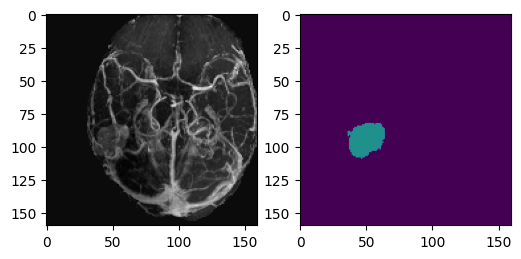

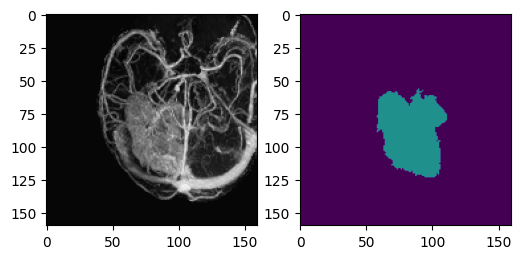

In [11]:
cnt = 0
for data in train_loader:
  print(data["image"].shape)
  print(data["label"].shape)

  for n in range(0,len(data["image"])):
    plt.figure(dpi=dpiv)
    plt.subplot(121)
    plt.imshow(np.transpose(np.max(data["image"][n,0,:,:,:].numpy(),axis=2),(1,0)),cmap='gray')

    label = (data["label"]==1).type(torch.FloatTensor) + (data["label"]==2).type(torch.FloatTensor) + (data["label"]==4).type(torch.FloatTensor) 
    plt.subplot(122)
    plt.imshow(np.transpose(np.max(label[n,0,:,:,:].numpy(),axis=2),(1,0)),vmin=0,vmax=2)
    plt.show()

  break
 

# Model

In [12]:
# standard PyTorch program style: create UNet, DiceLoss and Adam optimizer
device = torch.device("cuda:0")
model = UNet(
    dimensions=3,
    in_channels=1,
    out_channels=2,
    channels=(8, 16, 32, 64),
    strides=(2, 2, 2, 2),
    num_res_units=3,
    norm=Norm.BATCH,
).to(device)
loss_function = DiceLoss(to_onehot_y=True, softmax=True)


/usr/local/lib/python3.7/dist-packages/monai/networks/nets/unet.py:136: UserWarning: `len(strides) > len(channels) - 1`, the last 1 values of strides will not be used.
  warnings.warn(f"`len(strides) > len(channels) - 1`, the last {delta} values of strides will not be used.")


# Train

/usr/local/lib/python3.7/dist-packages/monai/transforms/post/array.py:177: UserWarning: `to_onehot=True/False` is deprecated, please use `to_onehot=num_classes` instead.
  warnings.warn("`to_onehot=True/False` is deprecated, please use `to_onehot=num_classes` instead.")


----------
epoch 1/32
epoch 1 average loss: 0.6148
----------
epoch 2/32
epoch 2 average loss: 0.5815
----------
epoch 3/32
epoch 3 average loss: 0.5578
----------
epoch 4/32
epoch 4 average loss: 0.5315
['/content/drive/MyDrive/data/brats18/brats18_train/Brats18_TCIA01_201_1/t1ce.nii.gz']


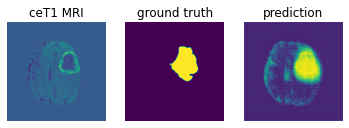

saved new best metric model
current epoch: 4 current mean dice: 0.4669
best mean dice: 0.4669 at epoch: 4
----------
epoch 5/32
epoch 5 average loss: 0.5185
----------
epoch 6/32
epoch 6 average loss: 0.5009
----------
epoch 7/32
epoch 7 average loss: 0.4860
----------
epoch 8/32
epoch 8 average loss: 0.4705
['/content/drive/MyDrive/data/brats18/brats18_train/Brats18_TCIA08_278_1/t1ce.nii.gz']


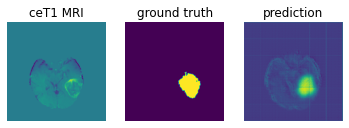

saved new best metric model
current epoch: 8 current mean dice: 0.4946
best mean dice: 0.4946 at epoch: 8
----------
epoch 9/32
epoch 9 average loss: 0.4611
----------
epoch 10/32
epoch 10 average loss: 0.4560
----------
epoch 11/32
epoch 11 average loss: 0.4362
----------
epoch 12/32
epoch 12 average loss: 0.4253
['/content/drive/MyDrive/data/brats18/brats18_train/Brats18_CBICA_AVG_1/t1ce.nii.gz']


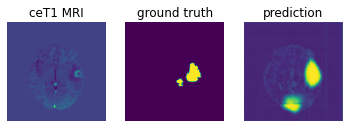

saved new best metric model
current epoch: 12 current mean dice: 0.5272
best mean dice: 0.5272 at epoch: 12
----------
epoch 13/32
epoch 13 average loss: 0.4139
----------
epoch 14/32
epoch 14 average loss: 0.4017
----------
epoch 15/32
epoch 15 average loss: 0.3872
----------
epoch 16/32
epoch 16 average loss: 0.3755
['/content/drive/MyDrive/data/brats18/brats18_train/Brats18_CBICA_ABO_1/t1ce.nii.gz']


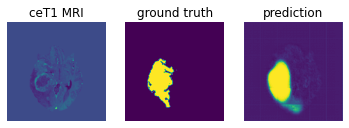

saved new best metric model
current epoch: 16 current mean dice: 0.5514
best mean dice: 0.5514 at epoch: 16
----------
epoch 17/32
epoch 17 average loss: 0.3547
----------
epoch 18/32
epoch 18 average loss: 0.3483
----------
epoch 19/32
epoch 19 average loss: 0.3528
----------
epoch 20/32
epoch 20 average loss: 0.3295
['/content/drive/MyDrive/data/brats18/brats18_train/Brats18_TCIA08_319_1/t1ce.nii.gz']


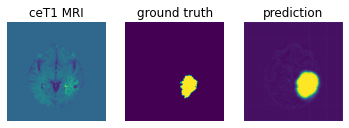

saved new best metric model
current epoch: 20 current mean dice: 0.5874
best mean dice: 0.5874 at epoch: 20
----------
epoch 21/32
epoch 21 average loss: 0.3109
----------
epoch 22/32
epoch 22 average loss: 0.3109
----------
epoch 23/32
epoch 23 average loss: 0.2977
----------
epoch 24/32
epoch 24 average loss: 0.2976
['/content/drive/MyDrive/data/brats18/brats18_train/Brats18_CBICA_AXJ_1/t1ce.nii.gz']


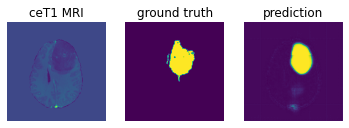

saved new best metric model
current epoch: 24 current mean dice: 0.6082
best mean dice: 0.6082 at epoch: 24
----------
epoch 25/32
epoch 25 average loss: 0.2803
----------
epoch 26/32
epoch 26 average loss: 0.2659
----------
epoch 27/32
epoch 27 average loss: 0.2689
----------
epoch 28/32
epoch 28 average loss: 0.2608
['/content/drive/MyDrive/data/brats18/brats18_train/Brats18_2013_17_1/t1ce.nii.gz']


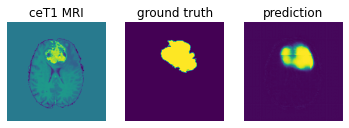

saved new best metric model
current epoch: 28 current mean dice: 0.6512
best mean dice: 0.6512 at epoch: 28
----------
epoch 29/32
epoch 29 average loss: 0.2469
----------
epoch 30/32
epoch 30 average loss: 0.2473
----------
epoch 31/32
epoch 31 average loss: 0.2303
----------
epoch 32/32
epoch 32 average loss: 0.2215
['/content/drive/MyDrive/data/brats18/brats18_train/Brats18_CBICA_ATP_1/t1ce.nii.gz']


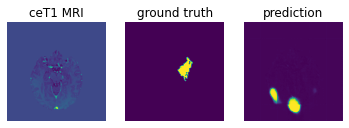

saved new best metric model
current epoch: 32 current mean dice: 0.6770
best mean dice: 0.6770 at epoch: 32


In [13]:
root_dir = path0 # model will be saved in this folder

lr = 1e-4
max_epochs = 32
val_interval = 4
best_metric = -1
best_metric_epoch = -1
epoch_loss_values = []
metric_values = []

optimizer = torch.optim.Adam(model.parameters(), lr)

for epoch in range(max_epochs):
    print("-" * 10)
    print(f"epoch {epoch + 1}/{max_epochs}")
    model.train()
    epoch_loss = 0
    step = 0
    for batch_data in train_loader:
        step += 1
        inputs, labels = (
            batch_data["image"].to(device),
            batch_data["label"],
        )

        labels = (labels==1).type(torch.FloatTensor) + (labels==2).type(torch.FloatTensor) + (labels==4).type(torch.FloatTensor)
        labels[labels>0] = 1
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = loss_function(outputs, labels)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()

    epoch_loss /= step
    epoch_loss_values.append(epoch_loss)
    print(f"epoch {epoch + 1} average loss: {epoch_loss:.4f}")
 
    if (epoch + 1) % val_interval == 0:
        model.eval()
        with torch.no_grad():
            metric_sum = 0.0
            metric_count = 0
            disp_val_no = np.random.randint(len(valid_files))
            for val_data in valid_loader:
                val_inputs, val_labels = (
                    val_data["image"].to(device),
                    val_data["label"],
                )        

                val_labels = (val_labels==1).type(torch.FloatTensor) + (val_labels==2).type(torch.FloatTensor) + (val_labels==4).type(torch.FloatTensor)
                val_labels[val_labels>0] = 1
                val_labels = val_labels.to(device)
                
                roi_size = (160, 160, 64)
                sw_batch_size = 4
                val_outputs = sliding_window_inference(
                    val_inputs, roi_size, sw_batch_size, model, overlap=0.75)
                val_loss = loss_function(val_outputs, val_labels)
                
                metric_count += 1
                metric_sum += (1-val_loss.sum().item())
                
                if metric_count == disp_val_no:
                  print(val_data['image_meta_dict']['filename_or_obj'])
                  zz = np.argmax(np.sum(np.sum(np.array(val_labels[0,0,:,:,:].cpu()),axis=1),axis=0))
                  val_preds = val_outputs.softmax(1)
                  plt.figure(dpi=dpiv)
                  plt.subplot(131)
                  plt.imshow(np.transpose(val_inputs[0,0,:,:,zz].cpu().numpy(),(1,0)),cmap='gray')
                  plt.axis('off')
                  plt.title('ceT1 MRI')
                  plt.subplot(132)
                  plt.imshow(np.transpose(val_labels[0,0,:,:,zz].cpu().numpy(),(1,0)))
                  plt.axis('off')
                  plt.title('ground truth')
                  plt.subplot(133)
                  plt.imshow(np.transpose(val_preds[0,1,:,:,zz].cpu().numpy(),(1,0)))
                  plt.axis('off')
                  plt.title('prediction')
                  plt.show()
                
            metric = metric_sum / metric_count
            metric_values.append(metric)
            
            if metric > best_metric:
                best_metric = metric
                best_metric_epoch = epoch + 1
                torch.save(model.state_dict(), os.path.join(
                    root_dir, f"best_metric_model_epoch_{best_metric_epoch}.pth"))    
                print("saved new best metric model")
            
            print(
                f"current epoch: {epoch + 1} current mean dice: {metric:.4f}"
                f"\nbest mean dice: {best_metric:.4f} "
                f"at epoch: {best_metric_epoch}")

## plot the loss and metric

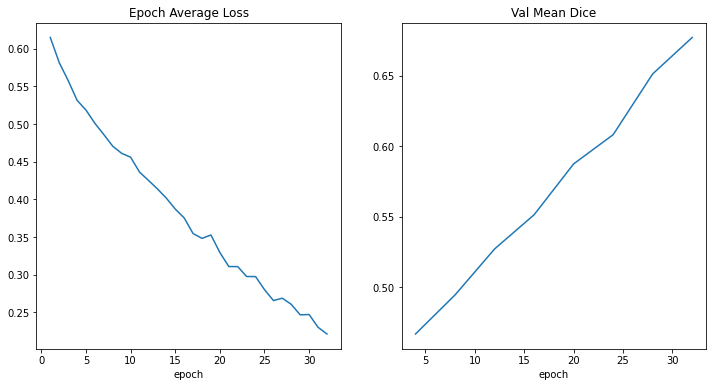

In [14]:
plt.figure("train", (12, 6))
plt.subplot(1, 2, 1)
plt.title("Epoch Average Loss")
x = [i + 1 for i in range(len(epoch_loss_values))]
y = epoch_loss_values
plt.xlabel("epoch")
plt.plot(x, y)
plt.subplot(1, 2, 2)
plt.title("Val Mean Dice")
x = [val_interval * (i + 1) for i in range(len(metric_values))]
y = metric_values
plt.xlabel("epoch")
plt.plot(x, y)
plt.show()

# Inference
- validation set 에 대해 가장 좋은 성능을 보여주었던 model을 불러와서 inference를 진행하고, 결과를 nifti파일로 저장합니다.

In [15]:
import nibabel as nib
path_out = os.path.join(path0,'valid_out') # the results will be saved in this folder
if os.path.isdir(path_out)==0:
  os.mkdir(path_out)

In [ ]:
#root_dir = '.'
#model.load_state_dict(torch.load(
#    os.path.join(root_dir, "best_metric_model_xxxxxx.pth")))


In [16]:
val_data = first(valid_loader)

['/content/drive/MyDrive/data/brats18/brats18_train/Brats18_CBICA_ANI_1/t1ce.nii.gz']


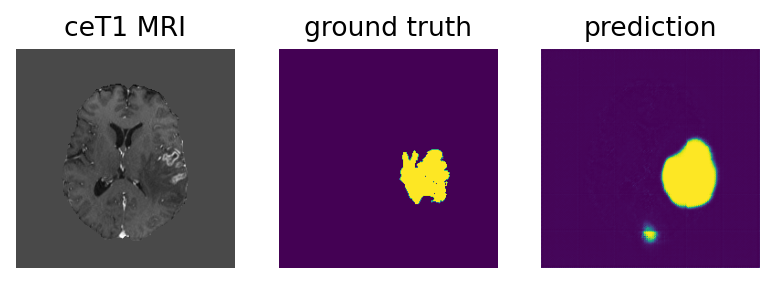

In [19]:
model.eval()
flag_save = 1

with torch.no_grad():
  val_inputs, val_labels = (
                      val_data["image"].to(device),
                      val_data["label"],
                  )        
  val_labels = (val_labels==1).type(torch.FloatTensor) + (val_labels==2).type(torch.FloatTensor) + (val_labels==4).type(torch.FloatTensor)
  val_labels[val_labels>0] = 1
  val_labels = val_labels.to(device)
  roi_size = (160, 160, 64)
  sw_batch_size = 4
  val_outputs = sliding_window_inference(
  val_inputs, roi_size, sw_batch_size, model, overlap=0.75)
  val_loss = loss_function(val_outputs, val_labels)

  
  print(val_data['image_meta_dict']['filename_or_obj'])
  zz = np.argmax(np.sum(np.sum(np.array(val_labels[0,0,:,:,:].cpu()),axis=1),axis=0))
  val_preds = val_outputs.softmax(1)
  plt.figure(dpi=dpiv*2)
  plt.subplot(131)
  plt.imshow(np.transpose(val_inputs[0,0,:,:,zz].cpu().numpy(),(1,0)),cmap='gray')
  plt.axis('off')
  plt.title('ceT1 MRI')
  plt.subplot(132)
  plt.imshow(np.transpose(val_labels[0,0,:,:,zz].cpu().numpy(),(1,0)))
  plt.axis('off')
  plt.title('ground truth')
  plt.subplot(133)
  plt.imshow(np.transpose(val_preds[0,1,:,:,zz].cpu().numpy(),(1,0)))
  plt.axis('off')
  plt.title('prediction')
  plt.show()

  if flag_save == 1:
    val_seg = torch.argmax(val_preds.cpu(),dim=1).numpy()
    pid = val_data['image_meta_dict']['filename_or_obj'][0].split('/')[-2]
    h = nib.load(val_data['image_meta_dict']['filename_or_obj'][0])
    h_new=nib.Nifti1Image(val_seg[0],h.affine,h.header)
    nib.save(h_new,os.path.join(path_out,pid+'.nii.gz'))
